In [3]:
# Common imports
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow.python.keras import backend as K
from tensorflow import set_random_seed

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

In [4]:
headers = ['date','abpmean','hr','pulse','resp','spo2','label']
dataset = pd.read_csv('dataset1.csv',names=headers)
# dataset = dataset.drop(dataset.columns[0], axis=1)
dataset.head()

,date,abpmean,hr,pulse,resp,spo2,label
0,'09:19:33 19/05/1995',113,100,100,22,100,0
1,'09:19:34 19/05/1995',113,100,100,22,99,0
2,'09:19:35 19/05/1995',113,100,101,20,99,0
3,'09:19:36 19/05/1995',113,101,101,21,98,0
4,'09:19:37 19/05/1995',113,101,102,21,98,0


In [5]:
# membagi data training dan data test 80%, 20%
from sklearn.model_selection import train_test_split

dataset.label = pd.factorize(dataset.label)[0]
X = dataset.iloc[:, 1:6]
y = dataset.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [6]:
# data train
X_train.head()

,abpmean,hr,pulse,resp,spo2
102,111,96,0,20,0
80,107,95,96,20,98
245,110,94,94,23,97
163,110,94,94,21,99
131,113,96,0,15,0


In [7]:
# data test
X_test.head()

,abpmean,hr,pulse,resp,spo2
285,108,95,95,24,98
248,109,94,94,23,97
150,112,95,96,25,100
217,109,93,92,23,98
107,112,99,0,19,0


In [8]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [9]:
# hasil min max xtrain
X_train

array([[0.71428571, 0.36363636, 0.        , 0.10227273, 0.        ],
       [0.14285714, 0.27272727, 0.93203883, 0.10227273, 0.98      ],
       [0.57142857, 0.18181818, 0.91262136, 0.13636364, 0.97      ],
       ...,
       [0.28571429, 0.45454545, 0.93203883, 0.11363636, 0.99      ],
       [0.42857143, 0.09090909, 0.90291262, 0.13636364, 0.99      ],
       [0.14285714, 0.63636364, 0.95145631, 0.10227273, 1.        ]])

In [10]:
# hasil min max xtest
X_test

array([[0.28571429, 0.33333333, 0.93137255, 0.12790698, 0.98      ],
       [0.42857143, 0.22222222, 0.92156863, 0.11627907, 0.97      ],
       [0.85714286, 0.33333333, 0.94117647, 0.13953488, 1.        ],
       [0.42857143, 0.11111111, 0.90196078, 0.11627907, 0.98      ],
       [0.85714286, 0.77777778, 0.        , 0.06976744, 0.        ],
       [0.42857143, 0.22222222, 0.87254902, 1.        , 0.98      ],
       [1.        , 0.44444444, 0.        , 0.11627907, 0.        ],
       [0.14285714, 0.55555556, 0.94117647, 0.09302326, 0.99      ],
       [0.28571429, 0.44444444, 0.94117647, 0.12790698, 0.99      ],
       [0.57142857, 0.55555556, 0.93137255, 0.09302326, 0.99      ],
       [0.28571429, 0.33333333, 0.92156863, 0.11627907, 0.99      ],
       [0.28571429, 0.66666667, 0.        , 0.15116279, 0.        ],
       [0.14285714, 0.55555556, 0.94117647, 0.09302326, 0.99      ],
       [0.14285714, 0.44444444, 0.96078431, 0.10465116, 0.99      ],
       [0.71428571, 0.55555556, 0.

In [11]:
# processing pca
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents_Xtrain = pca.fit_transform(X_train)
principalComponents_Xtest = pca.transform(X_test)
principalDf = pd.DataFrame(data = principalComponents_Xtrain, columns = ['principal component 1', 'principal component 2'])

In [12]:
principalDf.head()

,principal component 1,principal component 2
0,1.115406,-0.072485
1,-0.336053,-0.289228
2,-0.212895,-0.017534
3,-0.226211,-0.011964
4,1.187314,0.156985


In [13]:
# Calculate the covariance matrix
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [14]:
# Calculate the Mahalanobis distance
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [15]:
# Calculate threshold value for classifying datapoint as anomaly
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [16]:
# Detecting outliers
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [17]:
# # Calculate threshold value for classifying datapoint as anomaly
# def MD_threshold(dist, extreme=False, verbose=False):
#     k = 3. if extreme else 2.
#     threshold = np.mean(dist) * k
#     return threshold

In [18]:
# Check if matrix is positive definite
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [19]:
# Set up PCA model
data_train = np.array(principalComponents_Xtrain)
data_test = np.array(principalComponents_Xtrain)

In [20]:
# Calculate the covariance matrix and its inverse, based on data in the training set
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [21]:
# calculate the mean value for the input variables in the training set
mean_distr = data_train.mean(axis=0)

In [22]:
# calculate the Mahalanobis distance for the datapoints in the test set, and compare that with the anomaly threshold
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

(0.0, 15)

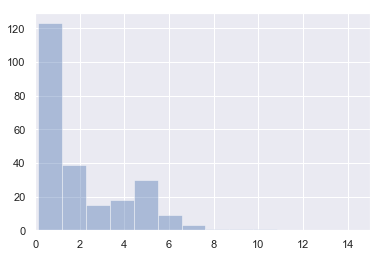

In [23]:
# visualizing the square of the Mahalanobis distance
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10, 
             kde= False);
plt.xlim([0.0,15])

Text(0.5, 0, 'Mahalanobis dist')

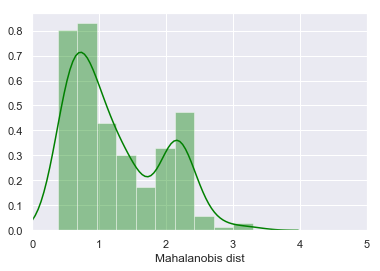

In [24]:
# visualize the Mahalanobis distance itself
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [29]:
# well as the threshold value and “anomaly flag” variable for both train and test data in a dataframe
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train = data_train

anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
# anomaly = data_test
anomaly.head()

,Mob dist,Thresh,Anomaly
0,2.073162,3.713669,False
1,1.326999,3.713669,False
2,0.398110,3.713669,False
3,0.419018,3.713669,False
4,2.275538,3.713669,False
